# 2022-09-09 • Connection test using template matching

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [5]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

## Peak-to-peak perf

In [177]:
perf = cached_conntest_eval(s, 1, p)
perf.detection_rates

(TPR_exc = 0.615, TPR_inh = 0.9, FPR = 0.125)

(this is just for one postsyn neuron. For all 40 recorded, see [here](https://tfiers.github.io/phd/nb/2022-09-01__1144_weights.html?highlight=average%20sta%20window#plot-perf:~:text=detplot(exc_post%2C%20%22excitatory%22)))

Can we get TPR_exc up?

Idea is to use a template STA to correlate STA with.
Here we'll cheat and use the average (E→E) STA as template (cheating cause it presumes knowledge of what's connected).
This is to test viability. If this works, we can move on to fitting a parametrized analytical STA shape to an individual STA (and then somehow compare it to shuffles..).

## Template: average STA

In [9]:
using PyPlot
using VoltoMapSim.Plot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:1239m39m


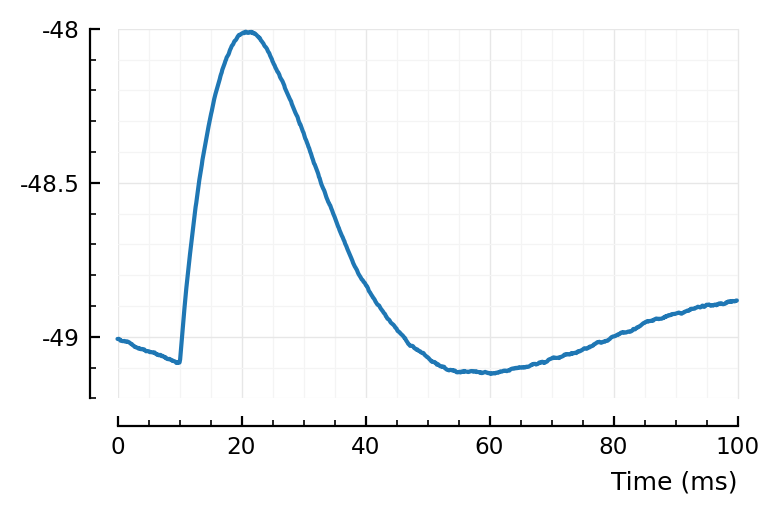

In [19]:
exc_post = [1:40;]
avgSTA = nothing
N = 0
@showprogress for n in exc_post
    ii = s.input_info[n]
    for m in ii.exc_inputs
        STA = calc_STA(m, n, s,p)
        if isnothing(avgSTA) avgSTA = STA
        else avgSTA .+= STA end
        N += 1
    end
end
avgSTA ./= N

plotsig(avgSTA / mV, p);

Great. Now we'll use this for conntest.

We'll take one difficult connection as example.
(See previous notebook)

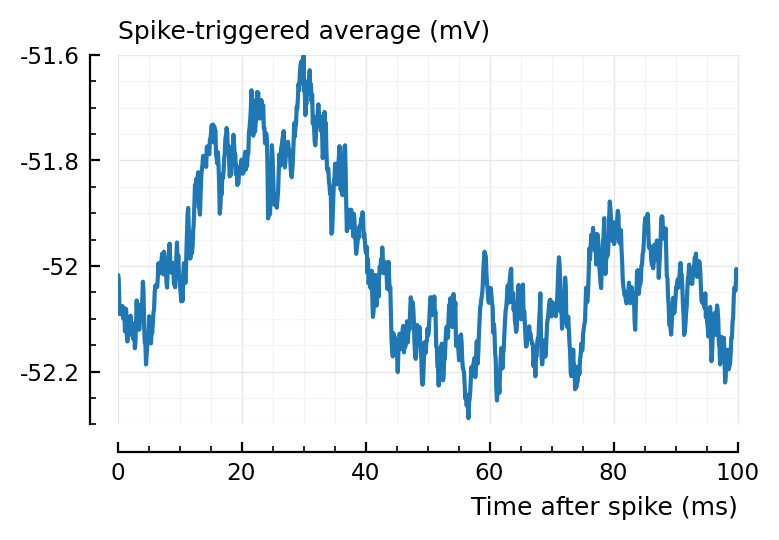

In [24]:
m = 136
n = 1
plotSTA(m, n, s,p);

Pval of 136 was 0.09.

In [35]:
STA = calc_STA(m,n,s,p);

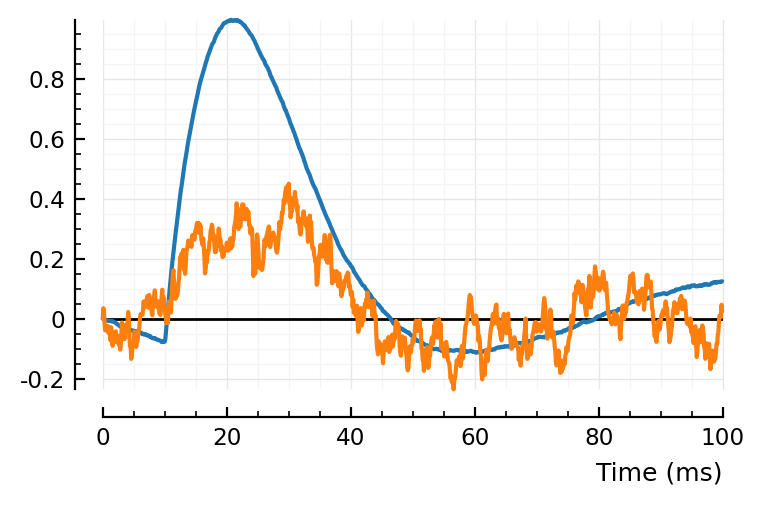

In [51]:
ref_to_start(sig) = sig .- sig[1]
fig,ax = plt.subplots()
plotsig(ref_to_start(avgSTA) / mV, p; ax)
plotsig(ref_to_start(STA) / mV, p; ax)
add_refline(ax);

And what if we ref to mean? (Which is what'd happen if we'd calculate (Pearson) correlation between signal and template).

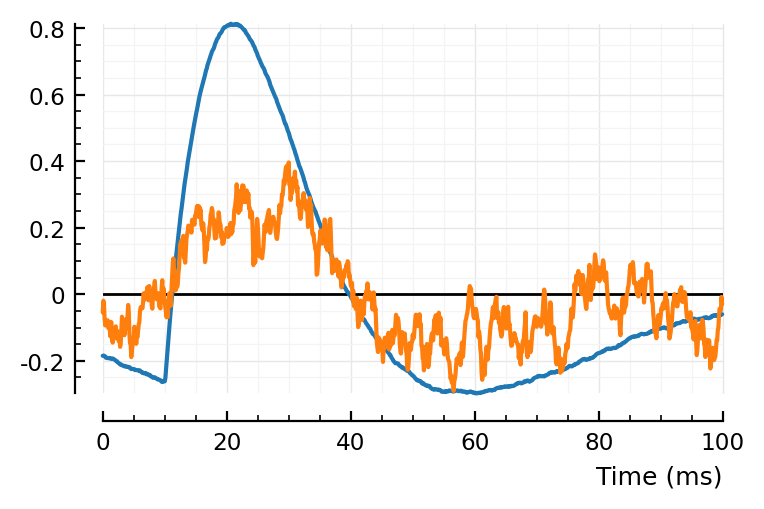

In [52]:
centre(sig) = sig .- mean(sig)
fig,ax = plt.subplots()
plotsig(centre(avgSTA) / mV, p; ax)
plotsig(centre(STA) / mV, p; ax)
add_refline(ax);

I like the former better, signals seem aligned better.

Though otoh, the first sample is more noisy than the mean of all samples of the STA.

Alright let's go for mean centring.

In [53]:
corr = cor(STA, avgSTA)

0.84

## Correlate shuffleds w/ template

Now do the same for shuffled STAs.

In [55]:
spikes = s.spike_times[m]
v = s.signals[n].v
shuffled_corrs = Float64[]
for i in 1:100
    shuffled_STA = calc_STA(v, shuffle_ISIs(spikes), p)
    push!(shuffled_corrs, cor(template, shuffled_STA))
end

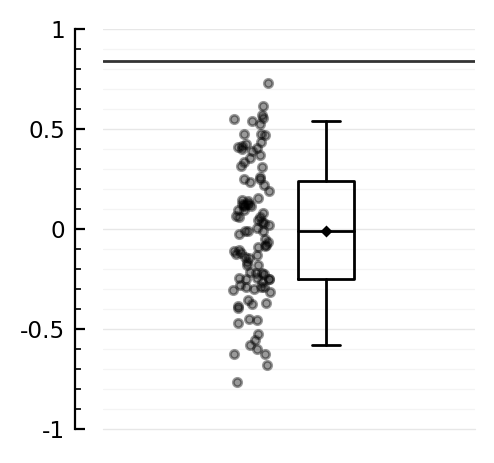

In [66]:
ydistplot(shuffled_corrs, ref = corr, ylim = [-1,1]);

Aha, so for this one we beat the p = 0.09 :)  
(with p < 0.01)

## Use as conntest, for all exc inputs

We went to apply to all `1`'s exc inputs now.

First, reuse our `test_connection` function in the codebase  
(we add an argument `f` to pass an arbitrary test statistic function).

In [69]:
test_statistic(STA) = cor(STA, avgSTA)

pval = test_connection(v, spikes, p, test_statistic)

0.01

Good, same as above.

In [83]:
ii = s.input_info[n]
corrs = Float64[]
pvals = Float64[]
@showprogress for m in ii.exc_inputs
    push!(pvals, test_connection(v, s.spike_times[m], p, test_statistic))
    push!(corrs, cor(calc_STA(m,n,s,p), avgSTA))
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [81]:
ENV["COLUMNS"] = 100;

In [84]:
tn = perf.tested_neurons
df = tn[tn.real_type .== :exc, :]
df.pval_with_template_corr = pvals
df.corr_with_template = corrs
df

,input_neuron_ID,real_type,predicted_type,pval,area_over_start,pval_with_template_corr,corr_with_template
,Int64,Symbol,Symbol,Float64,Float64,Float64,Float64
1,139,exc,exc,0.01,17,0.01,0.639
2,681,exc,inh,0.01,-4,0.01,0.814
3,11,exc,exc,0.01,18,0.01,0.844
4,766,exc,exc,0.01,52,0.01,0.939
5,132,exc,exc,0.03,18.5,0.12,0.504
6,516,exc,exc,0.01,30.4,0.01,0.95
7,418,exc,inh,0.01,-3.7,0.01,0.935
8,565,exc,unconn,0.05,18.7,0.01,0.735
9,597,exc,exc,0.01,26.3,0.01,0.956


Changes wrt previous statistic (peak-to-peak):
- 565, 136, 194, 352, 800 correctly detected now
- 101 and 33 still not detected (see prev nb for STA plots).
- 132 not detected anymore (and 337's p value went up to 0.04)

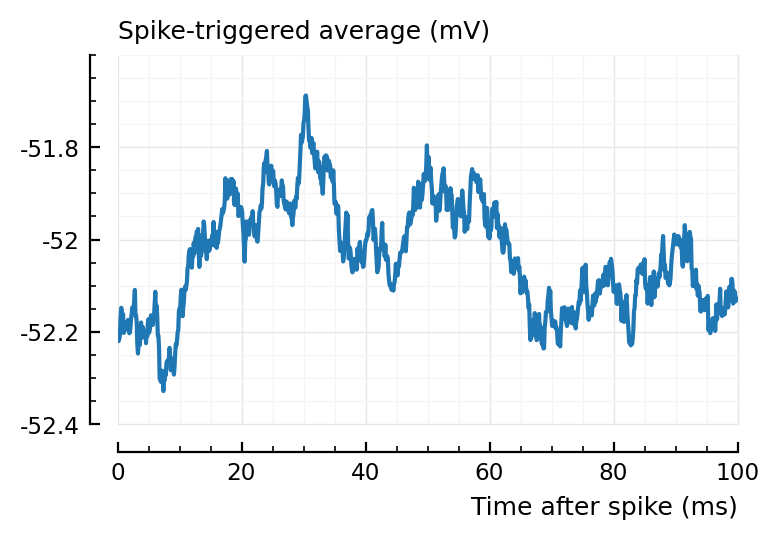

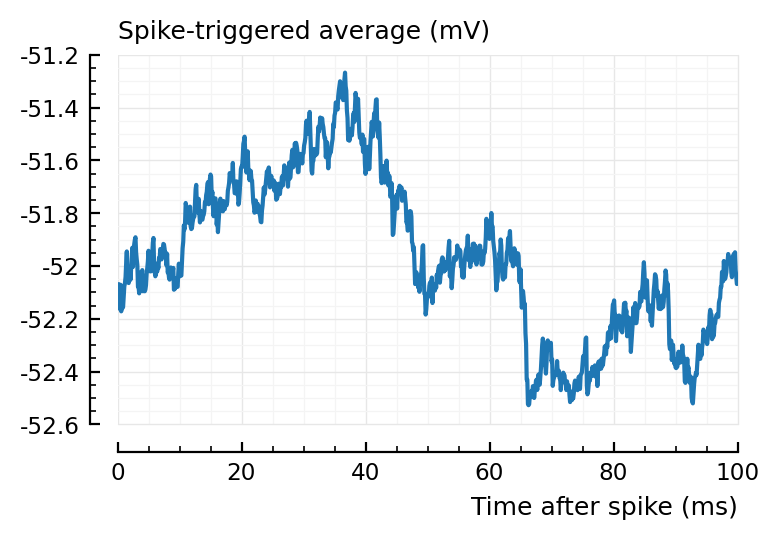

In [89]:
plotSTA(132, 1, s,p);
plotSTA(337, 1, s,p);

Ignoring the `predicted type == inh` for now (which is a different problem -- though we might solve by using `corr` instead of `area over start`) ..

In [96]:
df = df[df.predicted_type .!= :inh, :]
# TPR_exc_ptp = 
TPR_exc_ptp = count(df.pval .< 0.05) / nrow(df)

0.696

In [97]:
TPR_exc_template_match = count(df.pval_with_template_corr .< 0.05) / nrow(df)

0.87

That seems like an improvement.

## Same but for inh inputs

In [102]:
test_statistic(STA) = -cor(STA, avgSTA);

Here we use the negative corr as test stat.

This will require determining the type of a potential connection first, before deciding whether it exists.

In [103]:
corrs = Float64[]
pvals = Float64[]
@showprogress for m in ii.inh_inputs
    push!(pvals, test_connection(v, s.spike_times[m], p, test_statistic))
    push!(corrs, cor(calc_STA(m,n,s,p), avgSTA))
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [104]:
df = tn[tn.real_type .== :inh, :]
df.pval_with_template_corr = pvals
df.corrs_with_template = corrs
df

,input_neuron_ID,real_type,predicted_type,pval,area_over_start,pval_with_template_corr,corrs_with_template
,Int64,Symbol,Symbol,Float64,Float64,Float64,Float64
1,988,inh,inh,0.01,-8.34,0.01,-0.865
2,894,inh,inh,0.01,-52.9,0.01,-0.966
3,831,inh,exc,0.03,2.46,0.03,-0.563
4,902,inh,inh,0.01,-59.7,0.01,-0.977
5,897,inh,inh,0.01,-59.3,0.01,-0.979
6,928,inh,inh,0.01,-62.6,0.01,-0.97
7,914,inh,inh,0.01,-27,0.01,-0.972
8,829,inh,inh,0.01,-17.2,0.01,-0.932
9,908,inh,inh,0.01,-89.6,0.01,-0.873


Aha, the correlations are all negative.  
And they were all positive for the exc inputs. So this is a better exc-or-inh decider.

And same performance, voila :)

## Now for unconnected inputs.

In [126]:
df = tn[tn.real_type .== :unconn, :];

In [127]:
corrs = Float64[]
pvals = Float64[]
predtypes = Symbol[]
@showprogress for m in df.input_neuron_ID
    corr = cor(calc_STA(m,n,s,p), avgSTA)
    if (corr > 0) test_statistic(STA) = cor(STA, avgSTA)
    else          test_statistic(STA) = -cor(STA, avgSTA) end
    pval = test_connection(v, s.spike_times[m], p, test_statistic)
    if (pval ≥ 0.05)     predtype = :unconn
    elseif (corr > 0)    predtype = :exc
    else                 predtype = :inh end
    push!(pvals, pval)
    push!(corrs, corr)
    push!(predtypes, predtype)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


In [129]:
ENV["LINES"] = 100;
ENV["COLUMNS"] = 200;

In [130]:
df.predtype_corr = predtypes
df.pval_with_template_corr = pvals
df.corrs_with_template = corrs
df

,input_neuron_ID,real_type,predicted_type,pval,area_over_start,predtype_corr,pval_with_template_corr,corrs_with_template
,Int64,Symbol,Symbol,Float64,Float64,Symbol,Float64,Float64
1,23,unconn,unconn,0.42,31.2,unconn,0.51,0.0247
2,25,unconn,unconn,0.6,-13.3,unconn,0.21,-0.203
3,86,unconn,unconn,0.33,-11.2,unconn,0.32,0.121
4,113,unconn,unconn,0.64,-11,unconn,0.17,-0.385
5,197,unconn,unconn,0.65,1.15,unconn,0.1,0.416
6,227,unconn,unconn,0.95,9.94,unconn,0.2,0.336
7,230,unconn,unconn,0.39,7.05,unconn,0.2,-0.281
8,262,unconn,unconn,0.07,9.06,unconn,0.39,-0.0677
9,269,unconn,unconn,0.45,6.56,unconn,0.27,0.195


In [124]:
FPR__ptp = count(df.pval .< 0.05) / nrow(df)

0.125

In [125]:
FPR__template_match = count(df.pval_with_template_corr .< 0.05) / nrow(df)

0.125

So no change in the FPR (at α 0.05 at least).

Plot the interesting cases where predictions differ.

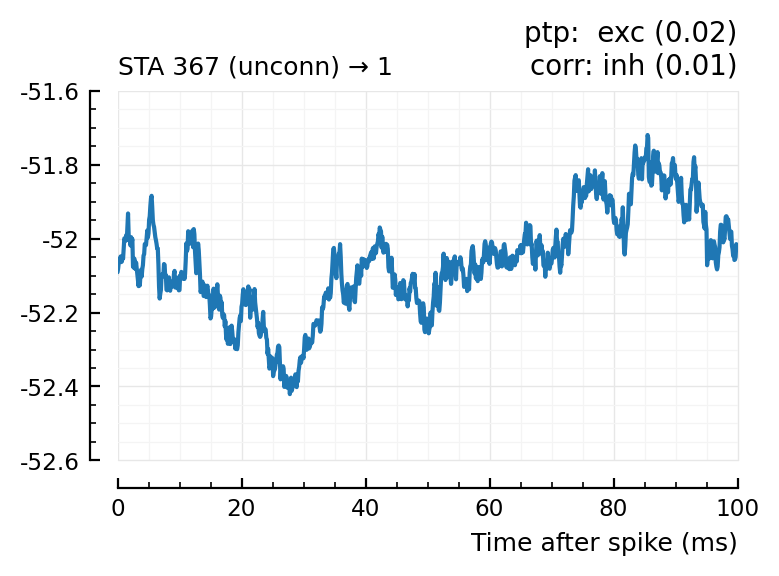

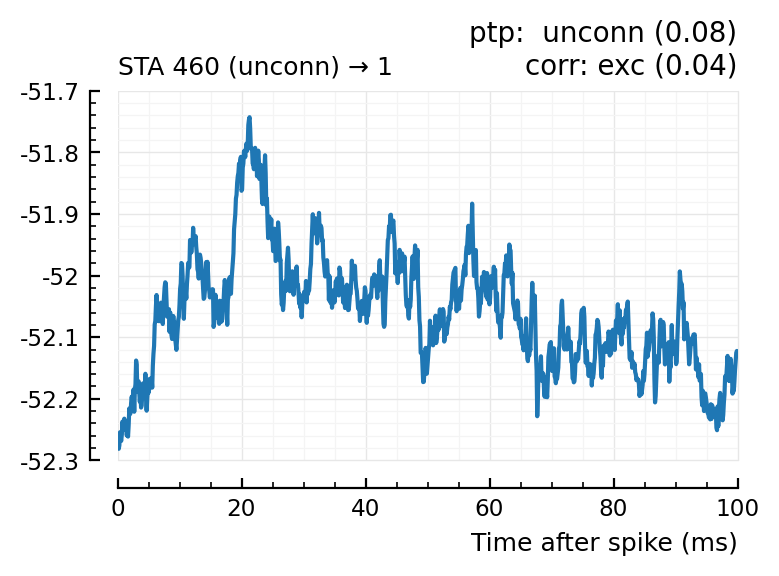

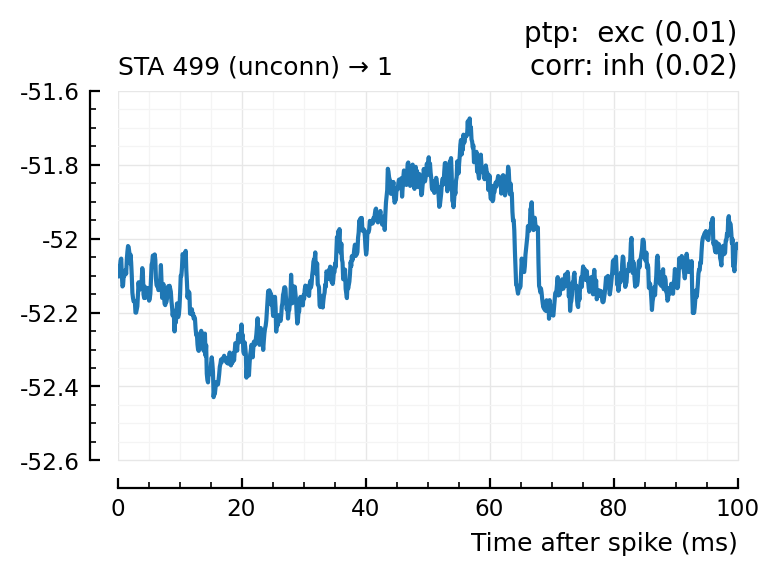

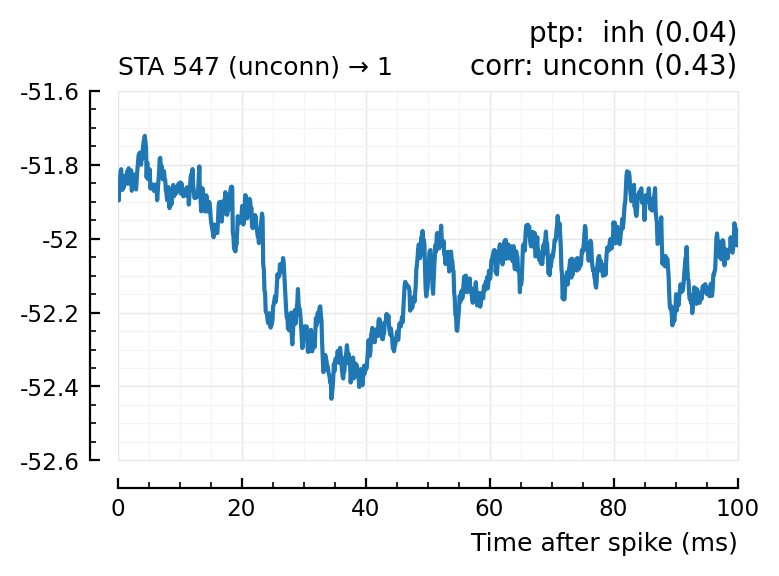

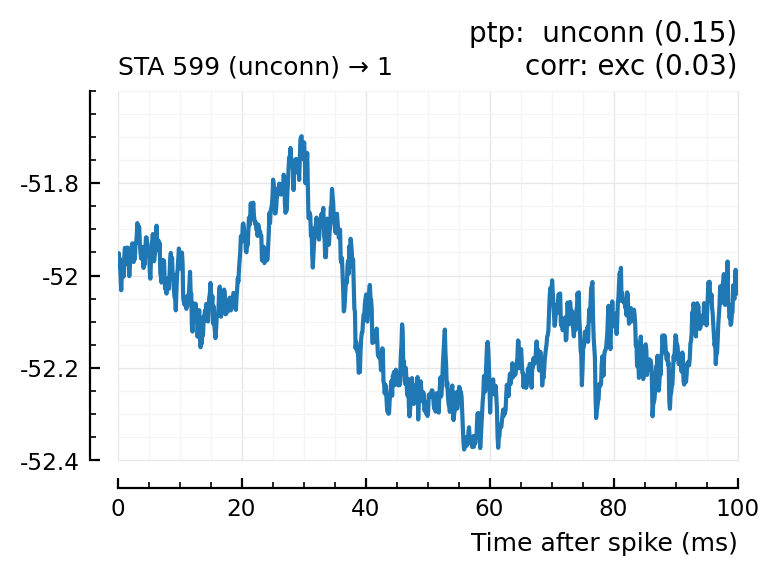

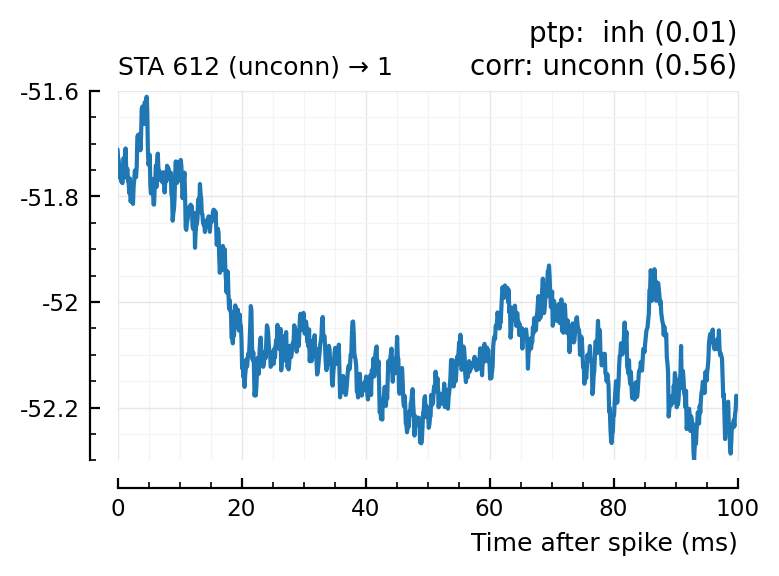

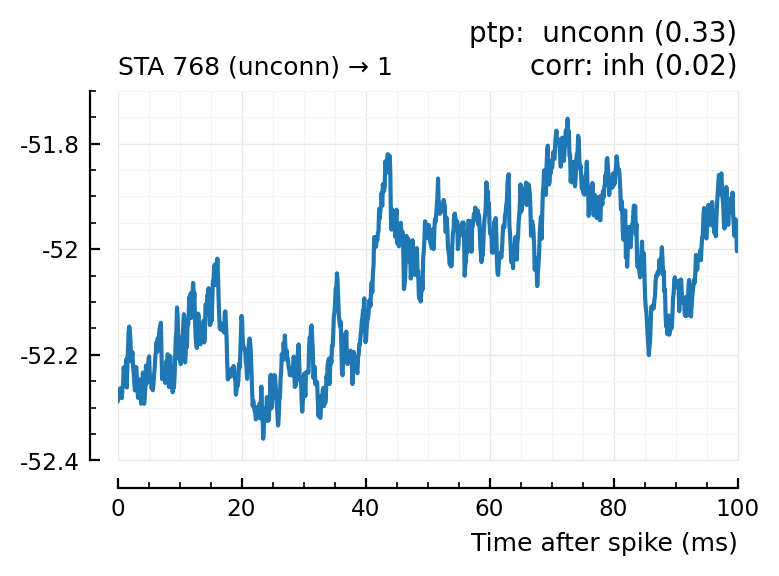

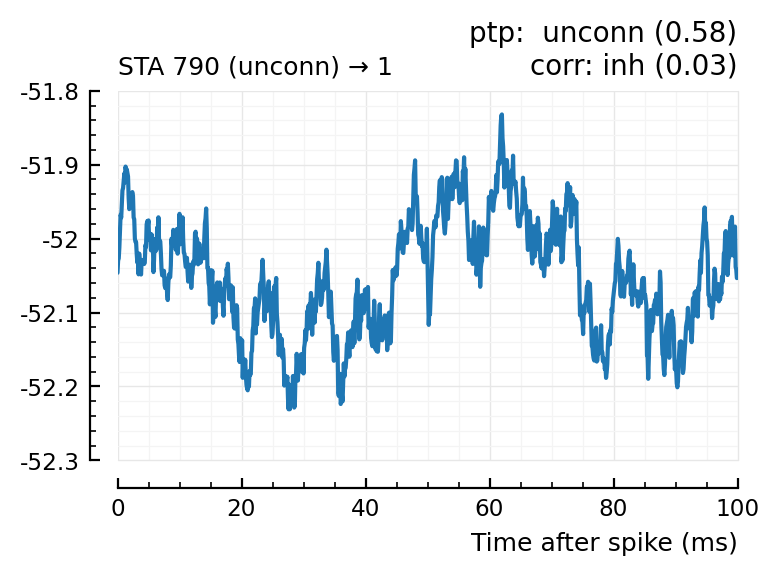

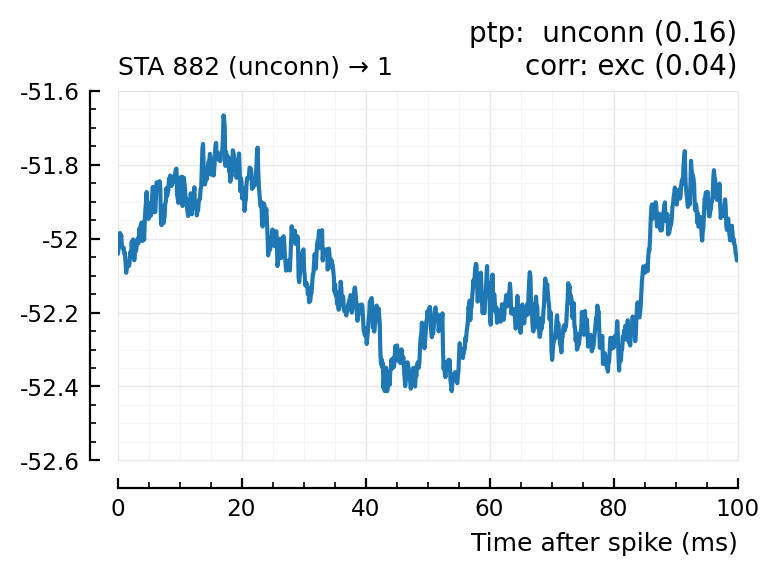

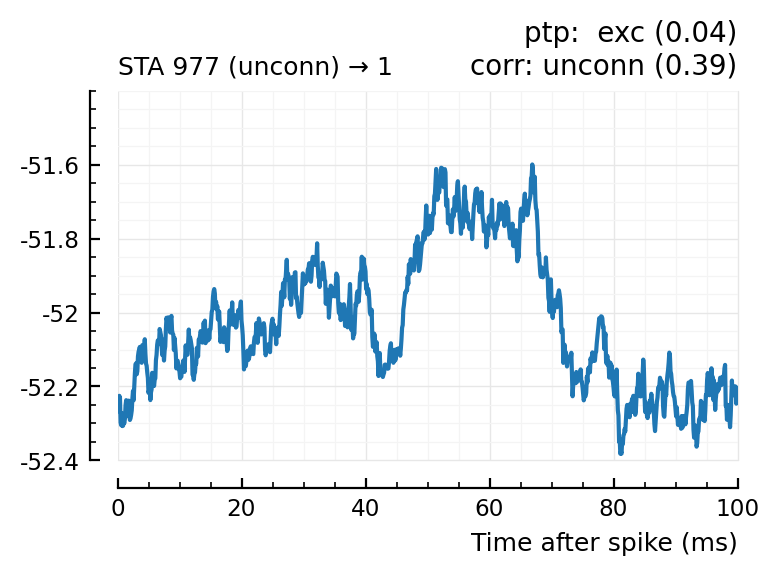

In [136]:
function plotcase(m)
    row = first(df[df.input_neuron_ID .== m, :])
    title = jn("ptp:  $(row.predicted_type) ($(row.pval))",
               "corr: $(row.predtype_corr) ($(row.pval_with_template_corr))")
    plotSTA(m,n,s,p, hylabel="STA $m (unconn) → $n"; title)
end
for m in df[(df.predicted_type .!= :unconn) .| (df.predtype_corr .!= :unconn), :].input_neuron_ID
    plotcase(m)
end

(For comparison, some clearly unconnecteds):

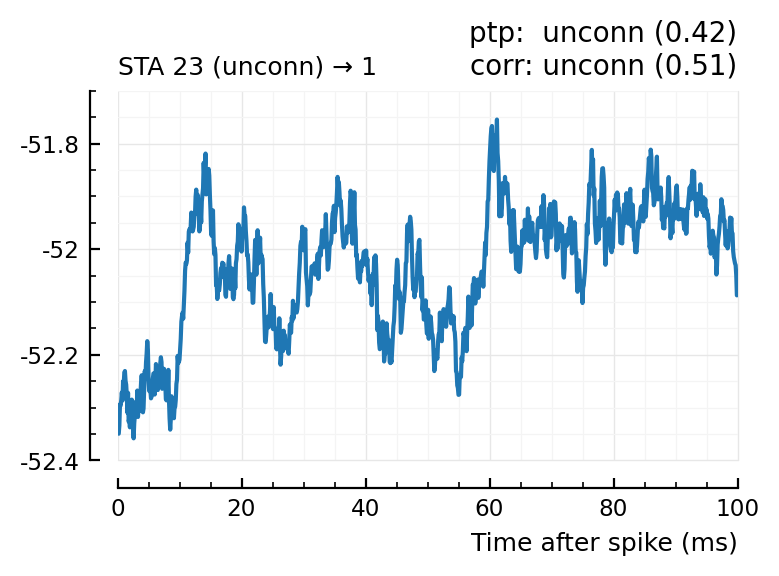

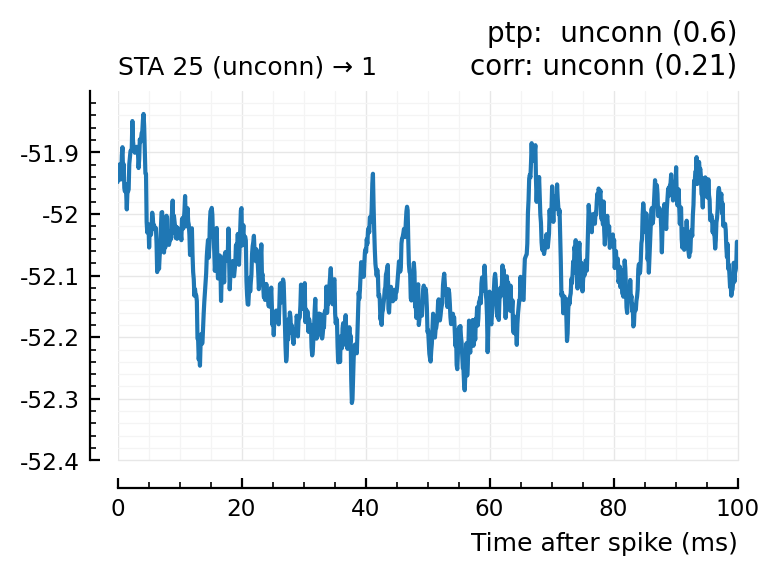

In [137]:
plotcase(23);
plotcase(25);

Now, apply this to all recorded postsynaptic neurons.

For that, we'll add this connection test (and connection type test) to our codebase.

## Copy-and-edit from codebase

(These functions use external var `avgSTA`).

In [173]:
# Renaming some existing funcs 
STA_shuffle_test             = VoltoMapSim.test_connection
test_conn_using_ptp_and_area = VoltoMapSim.test_connection_and_type;

In [174]:
function test_conn_using_corr(v, spikes, p::ExpParams)
    @unpack α = p.evaluation
    STA = calc_STA(v, spikes, p)
    corr = cor(STA, avgSTA)
    if (corr > 0) test_stat = STA -> cor(STA, avgSTA)
    else          test_stat = STA -> -cor(STA, avgSTA) end
        # have to use anonymous funcs here: https://stackoverflow.com/a/65660721/2611913
    pval = STA_shuffle_test(v, spikes, p, test_stat)
    if     (pval ≥ α)  predtype = :unconn
    elseif (corr > 0)  predtype = :exc
    else               predtype = :inh end
    return predtype, (; pval, corr)
end;

In [213]:
function evaluate_conntest_perf_v3(s, m, p::ExperimentParams, verbose = true, testfunc = test_conn_using_ptp_and_area)
    # s = augmented simdata
    # m = postsynaptic neuron ID
    # testfunc is a function taking (voltage, spikes, p) and 
    #   returning (predicted_type::Symbol, extra_info::NamedTuple)
    @unpack N_tested_presyn, rngseed = p.evaluation;
    resetrng!(rngseed)
    function get_IDs_labels(IDs, label)
        # Example output: `[(3, :exc), (5, :exc), (12, :exc), …]`.
        N = min(length(IDs), N_tested_presyn)
        IDs_sample = sample(IDs, N, replace = false, ordered = true)
        return zip(IDs_sample, fill(label, N))
    end
    ii = s.input_info[m]
    IDs_labels = chain(
        get_IDs_labels(ii.exc_inputs, :exc),
        get_IDs_labels(ii.inh_inputs, :inh),
        get_IDs_labels(ii.unconnected_neurons, :unconn),
    ) |> collect    
    tested_neurons = DataFrame(
        input_neuron_ID = Int[],     # global ID
        real_type       = Symbol[],  # :unconn, :exc, :inh
        predicted_type  = Symbol[],  # idem
    )
    extra_infos = []
    N = length(IDs_labels)
    pbar = Progress(N, desc = "Testing connections: ", enabled = verbose, dt = 400ms)
    for (n, label) in IDs_labels
        predtype, extra_info = testfunc(ii.v, s.spike_times[n], p)
        row = (
            input_neuron_ID = n,
            real_type       = label,
            predicted_type  = predtype,
        )
        push!(tested_neurons, Dict(pairs(row)))
        push!(extra_infos, extra_info)
        next!(pbar)
    end
    tn = tested_neurons
    # Add `extra_info` columns to table
    colnames = keys(first(extra_infos))
    for colname in colnames
        tn[!, colname] = [tup[colname] for tup in extra_infos]
    end
    # Calculate detection rates (false positive and true positive rates)
    det_rate(t) = count((tn.real_type .== t) .& (tn.predicted_type .== t)) / count(tn.real_type .== t)
    detection_rates = (
        TPR_exc = det_rate(:exc),
        TPR_inh = det_rate(:inh),
        FPR = 1 - det_rate(:unconn),
    )
    return perf = (; tested_neurons, detection_rates)
end

cached_conntest_eval_v3(s, m, p; verbose = true, testfunc = test_conn_using_ptp_and_area) =
    cached(evaluate_conntest_perf_v3, [s, m, p, verbose, testfunc]; key = [m, p, string(testfunc)], verbose);

In [176]:
perf = cached_conntest_eval_v3(s, 1, p; testfunc = test_conn_using_corr)
perf.detection_rates

Testing connections: 100%|██████████████████████████████| Time: 0:00:31
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf_v3\a17be8fa72748bbc.jld2` … done (6.2 s)


(TPR_exc = 0.885, TPR_inh = 1, FPR = 0.125)

In [344]:
# evaluate_conntest_perf_v3(s, 1, p, true, test_conn_using_corr)

Cool, works (and we now get our final improvement for neuron `1`, with the new exc/inh decider too).
Peak-to-peak and area performance (from above):  
`(TPR_exc = 0.615, TPR_inh = 0.9, FPR = 0.125)`

Now apply to all 50 recorded postsynaptic neurons

## Conntest all recorded neurons

In [180]:
using Base.Threads
detrates_corr = Dict()
recorded_neurons = p.sim.network.record_v
pbar = Progress(length(recorded_neurons))
@threads for m in recorded_neurons
    perf = cached_conntest_eval_v3(s, m, p, verbose = false, testfunc = test_conn_using_corr)
    detrates_corr[m] = perf.detection_rates
    next!(pbar)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:12:39


(Time taken: ~13 minutes).

In [553]:
function statstable(funcs, df; funcnames = string.(funcs), print = true, funcs_are_rows = true)
    # Apply each function in `funcs` to each column of the given DataFrame.
    statcols = [
        fname => [f(col) for col in eachcol(df)]
        for (f, fname) in zip(funcs, funcnames)
    ]
    df = DataFrame("" => names(df), statcols...)
    if (funcs_are_rows) df = permutedims(df, 1) end
    if print
        printsimple(df, formatters = ft_printf("%.2f"), alignment = :r)
        println()
    end
    return df
end;

In [564]:
to_df(detrates::Dict, ids) = DataFrame([detrates[n] for n in ids])

title(groupname, ids) = "Detection rates for $groupname neurons (n = $(length(ids)))"

detrate_distplot(detrates::DataFrame, hylabel) = ydistplot(
    "Exc. inputs" => detrates.TPR_exc,
    "Inh. inputs" => detrates.TPR_inh,
    "Unconn."     => detrates.FPR;
    ylim = [0,1],
    hylabel,
    ref = p.evaluation.α,
)
detrate_distplot(detrates, ids, groupname) = detrate_distplot(to_df(detrates, ids), title(groupname, ids))

function table(detrates, ids, groupname)
    println("\n", title(groupname, ids), ":", "\n")
    statstable([mean, median], to_df(detrates, ids))
    println("\n")
end;

function call_for_both(f, detrates)
    f(detrates, exc_post, "excitatory")
    f(detrates, inh_post, "inhibitory")
end

detrate_distplots(detrates) = call_for_both(detrate_distplot, detrates)
tables(detrates)            = call_for_both(table, detrates);

In [555]:
exc_post = 1:40
inh_post = 801:810;

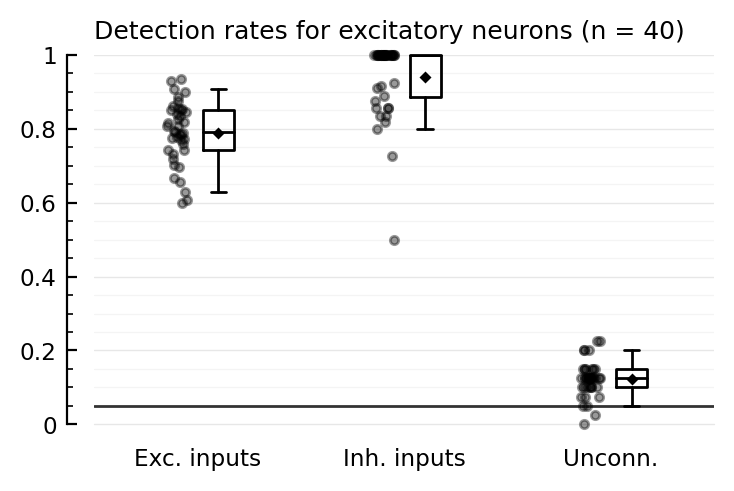

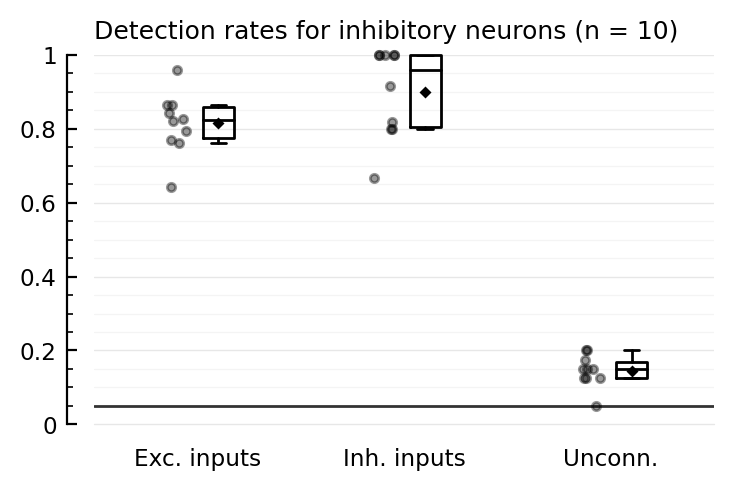

In [556]:
detrate_distplots(detrates_corr);

In [565]:
tables(detrates_corr);


Detection rates for excitatory neurons (n = 40):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.79     0.94  0.12
 median     0.79     1.00  0.12



Detection rates for inhibitory neurons (n = 10):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.81     0.90  0.15
 median     0.82     0.96  0.15




(Could do a 95% confidence interval on e.g. median by bootstrap).

## Compare with before (peak-to-peak & area-over-start)

In [410]:
detrates_ptp = Dict()
@showprogress for m in neurons
    perf = cached_conntest_eval(s, m, p, verbose = false)  # note: the previous eval func
    detrates_ptp[m] = perf.detection_rates
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [566]:
tables(detrates_ptp)


Detection rates for excitatory neurons (n = 40):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.57     0.85  0.13
 median     0.57     0.88  0.12



Detection rates for inhibitory neurons (n = 10):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.59     0.84  0.15
 median     0.57     0.81  0.15




## Match with template but not using correlation; ref to start

In [186]:
ref_to_start(sig) = sig .- sig[1]
correspondence_with_template(STA) = mean(ref_to_start(STA) .* ref_to_start(avgSTA));

In [194]:
function test_conn_using_match_and_ref_to_start(v, spikes, p::ExpParams)
    @unpack α = p.evaluation
    STA = calc_STA(v, spikes, p)
    corr = correspondence_with_template(STA)
    if (corr > 0) test_stat = STA -> correspondence_with_template(STA)
    else          test_stat = STA -> -correspondence_with_template(STA) end
    pval = STA_shuffle_test(v, spikes, p, test_stat)
    if     (pval ≥ α)  predtype = :unconn
    elseif (corr > 0)  predtype = :exc
    else               predtype = :inh end
    return predtype, (; pval, corr_mV2 = corr / (mV^2))
end;

In [195]:
perf = cached_conntest_eval_v3(s, 1, p; testfunc = test_conn_using_match_and_ref_to_start)
perf.detection_rates

Testing connections: 100%|██████████████████████████████| Time: 0:00:30
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf_v3\3d3e47c80c129767.jld2` … done


(TPR_exc = 0.769, TPR_inh = 0.9, FPR = 0.2)

Hah, so it works, but not as good as with correlation!

For all neurons:

In [200]:
detrates_startref = Dict()
pbar = Progress(length(recorded_neurons))
@threads for m in recorded_neurons
    perf = cached_conntest_eval_v3(s, m, p, verbose = false, testfunc = test_conn_using_match_and_ref_to_start)
    detrates_startref[m] = perf.detection_rates
    next!(pbar)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:12:33


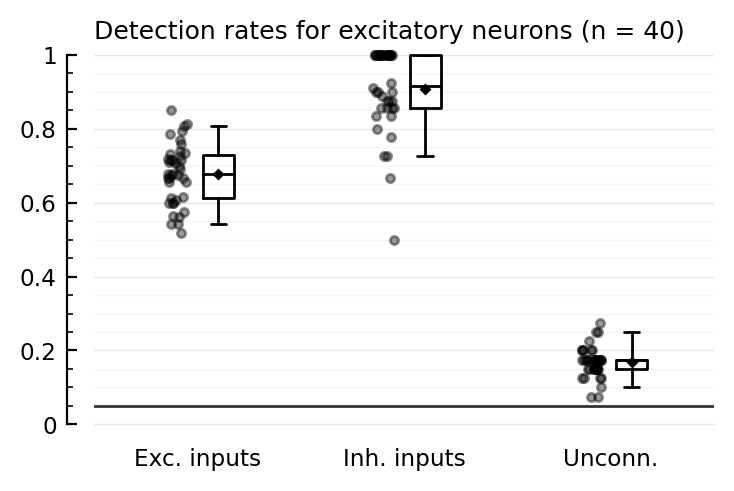

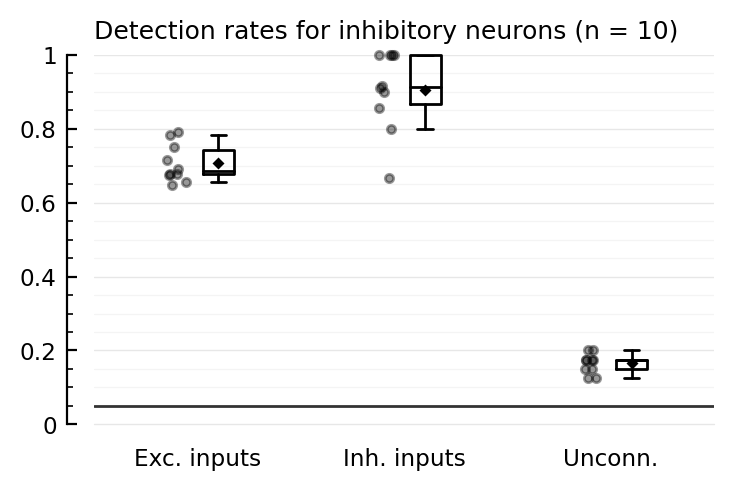

In [569]:
detrate_distplots(detrates_startref);

In [570]:
tables(detrates_startref);


Detection rates for excitatory neurons (n = 40):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.68     0.91  0.17
 median     0.68     0.92  0.18



Detection rates for inhibitory neurons (n = 10):

         TPR_exc  TPR_inh  FPR  
────────────────────────────────
   mean     0.71     0.90  0.16
 median     0.69     0.91  0.18




## Compare all three

We'll take the median.

In [703]:
maindf = DataFrame(
    test_method = String[],
    postsyn_type = Symbol[],
    detrate_type = Symbol[],
    median = Float64[],
)
data = [
    "ptp-area"     => detrates_ptp,
    "corr"         => detrates_corr,
    "ref-to-start" => detrates_startref,
]
for (test_method, detrates) in data, postsyn_type in (:exc, :inh)
    group = (postsyn_type == :exc) ? exc_post : inh_post
    df = to_df(detrates, group)
    for (detrate_type, col) in pairs(eachcol(df))
        row = (; test_method, postsyn_type, detrate_type, median = median(col))
        push!(maindf, Dict(pairs(row)))
    end
end

df = copy(maindf)
sort!(df, [:detrate_type, :postsyn_type])
rename!(df, "postsyn_type" => "postsyn", "detrate_type" => "")
printsimple_(df) = printsimple(df, formatters = ft_printf("%.2f"), alignment = :r)
printsimple_(df);

 test_method   postsyn           median 
────────────────────────────────────────
     ptp-area      exc      FPR    0.12
         corr      exc      FPR    0.12
 ref-to-start      exc      FPR    0.18
     ptp-area      inh      FPR    0.15
         corr      inh      FPR    0.15
 ref-to-start      inh      FPR    0.18
     ptp-area      exc  TPR_exc    0.57
         corr      exc  TPR_exc    0.79
 ref-to-start      exc  TPR_exc    0.68
     ptp-area      inh  TPR_exc    0.57
         corr      inh  TPR_exc    0.82
 ref-to-start      inh  TPR_exc    0.69
     ptp-area      exc  TPR_inh    0.88
         corr      exc  TPR_inh    1.00
 ref-to-start      exc  TPR_inh    0.92
     ptp-area      inh  TPR_inh    0.81
         corr      inh  TPR_inh    0.96
 ref-to-start      inh  TPR_inh    0.91

- `ptp-area` is what we did before (peak-to-peak of STA, and area-over-start to decide whether exc or inh.
- `corr` is correlation of STA with template (which is average E→E STA)
- `ref-to-start` is like corr, but using `mean(ref(STA) .* ref(avgSTA))` where `ref` centers around starting value (instead of around mean).

So:
- regarding FPR, `corr` is no better or worse than `ptp-area`. `ref-to-start` is worse.
- for all TPRs, `ref-to-start` is better than the previous `ptp-area`, and `corr` is even better.

Filtering and widening the table to highlight the detection improvements:

In [725]:
df = copy(maindf)
subset!(df, :test_method => ByRow(!=("ref-to-start")), :detrate_type => ByRow(!=(:FPR)))
df = unstack(df, :test_method, :median)
transform!(df, :detrate_type => ByRow(x -> string(x)[end-2:end]) => :pre, :postsyn_type => ByRow(string) => :post)
sort!(df, :pre)
select!(df, [:pre, :post] => ByRow((pre,post) -> "$pre → $post") => "", "ptp-area" => "before", "corr" => "after");

## Summary

In [726]:
println("Median detection rate:\n")
printsimple_(df)

Median detection rate:

            before  after 
──────────────────────────
 exc → exc    0.57   0.79
 exc → inh    0.57   0.82
 inh → exc    0.88   1.00
 inh → inh    0.81   0.96

(And median FPRs stay the same).

Significant improvement.

Still, 1 out of 5 exc inputs still not detected (before was 2 out of 5).  

Looking at their STAs though (101 and 33 ([here][1]), and 132 (here above)), it makes sense they're not detected: the STAs look like noise. Still, why do these inputs have a weaker STA?

Also, we're still cheating (with `avgSTA` as template to correlate with). Now time to play fair and fit a func.  
How much of improvement will remain :p

[1]: https://tfiers.github.io/phd/nb/2022-09-05__Why-not-detected.html#id1:~:text=plott(101)%3B%0Aplott(33)%3B